- Grid: $0, \Delta x, ..., \Delta x \cdot (N - 1)$
- Set even derivatives at $x_0=0$ and $x_1 = \Delta x * ( N - 1)$ to $0$
- Uneven derivatives are given by $f^{(1)}(x_0), f^{(1)}(x_1), f^{(3)}(x_0), f^{(3)}(x_1), $...
- Define antisymmetric extension as {$f(x_0), ..., f(x_1), -f(x_1 - \Delta x), ..., -f(x_0 + \Delta x)$}

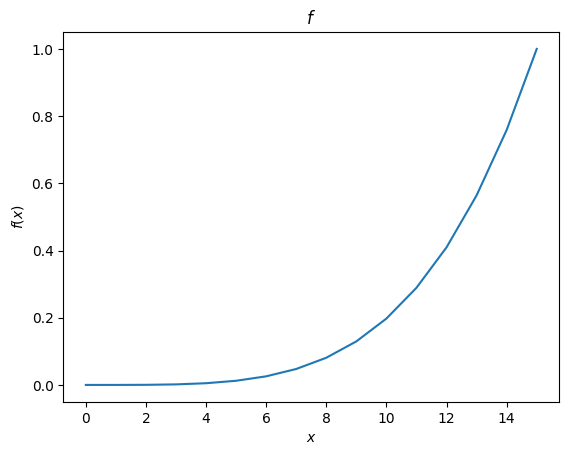

([(2, 9.640725717741105e-14), (4, 6.639220423432235e-11), (6, 4.0277937235488897e-07), (8, 1215000.000113808), (10, -0.013380400303367181), (12, -1.829401620424484), (14, -2273.6077028641694), (16, -60709.21494550887)], [(2, 59.99999999999899), (4, 2699.9999999991633), (6, 80999.9999995999), (8, 1214999.9997575665), (10, -0.07989827549570451), (12, -13.59807188724971), (14, -1814.9968832557875), (16, -105010.53395979914)])


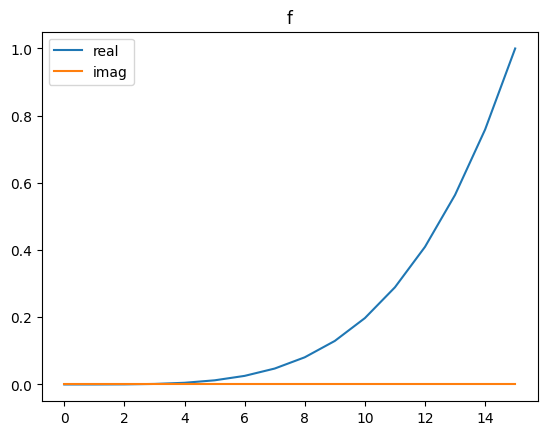

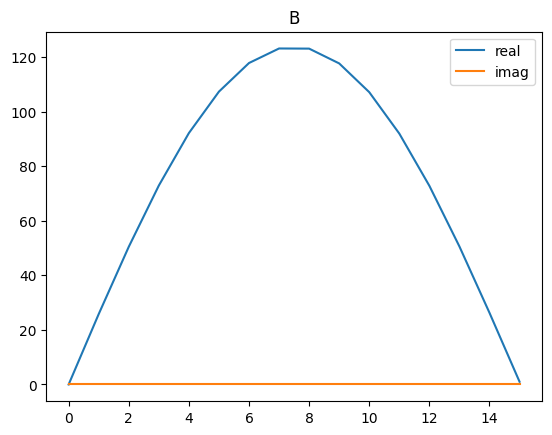

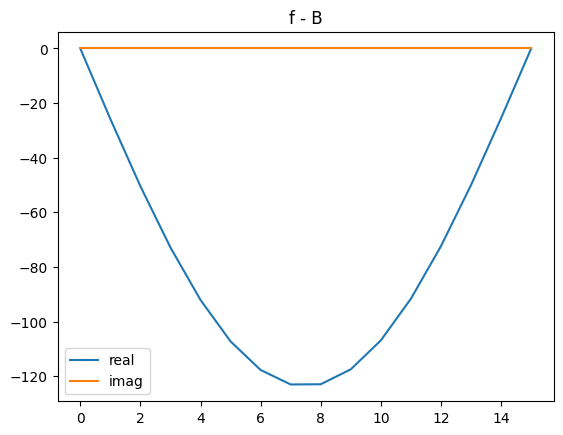

f[lb] = 0.0 f[rb] = 1.0 B[0][lb] = 7.727270021076433e-08  B[0][rb] = 1.0 homf[lb] = -7.727270021076433e-08 homf[rb] = 0.0


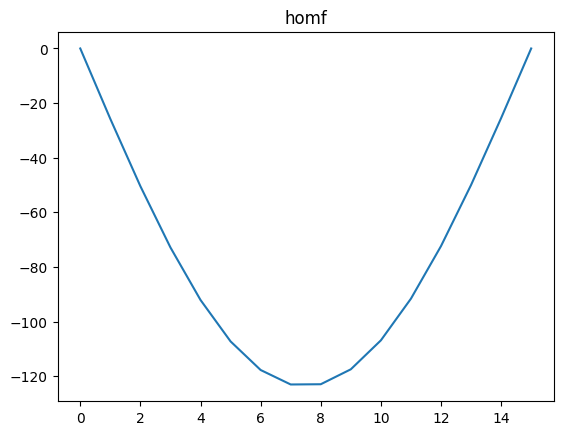

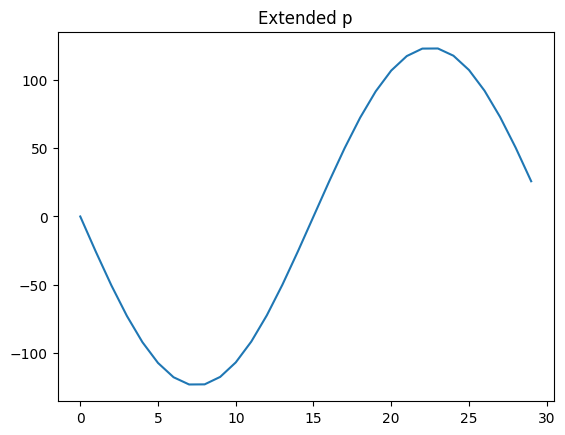

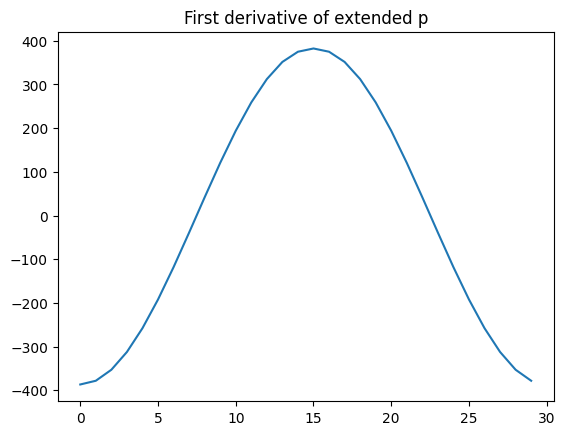

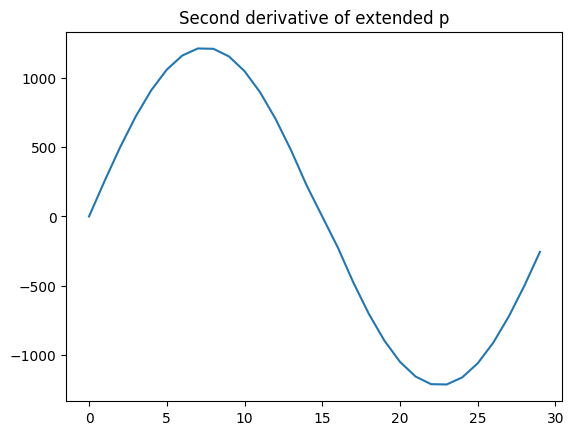

The extended p:  [-7.72727002e-08 -2.57893756e+01 -5.04426192e+01 -7.28746467e+01
 -9.21001335e+01 -1.07277169e+02 -1.17743917e+02 -1.23046866e+02
 -1.22959710e+02 -1.17492396e+02 -1.06890336e+02 -9.16242514e+01
 -7.23716055e+01 -4.99910442e+01 -2.54917382e+01  0.00000000e+00
  2.54917382e+01  4.99910442e+01  7.23716055e+01  9.16242514e+01
  1.06890336e+02  1.17492396e+02  1.22959710e+02  1.23046866e+02
  1.17743917e+02  1.07277169e+02  9.21001335e+01  7.28746467e+01
  5.04426192e+01  2.57893756e+01]
-25.789375561961112 -24.653243534209075


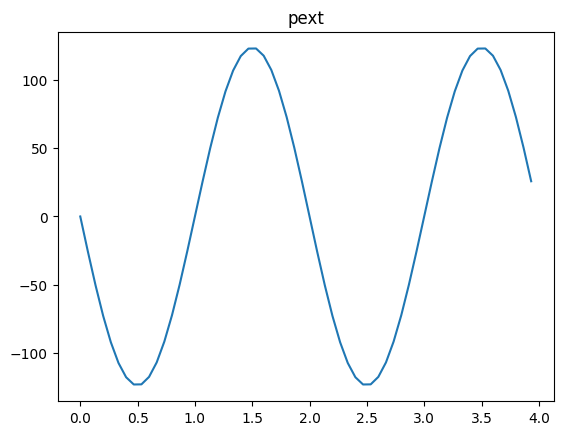

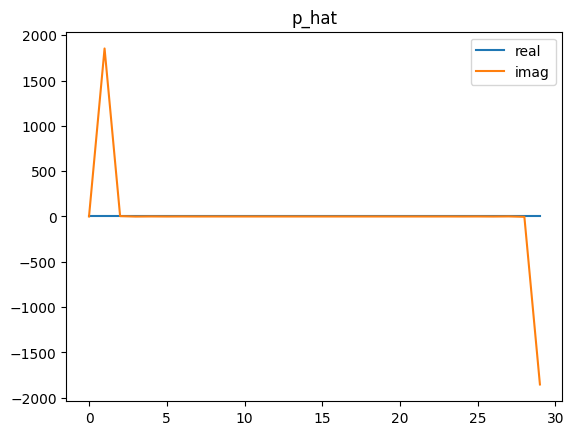

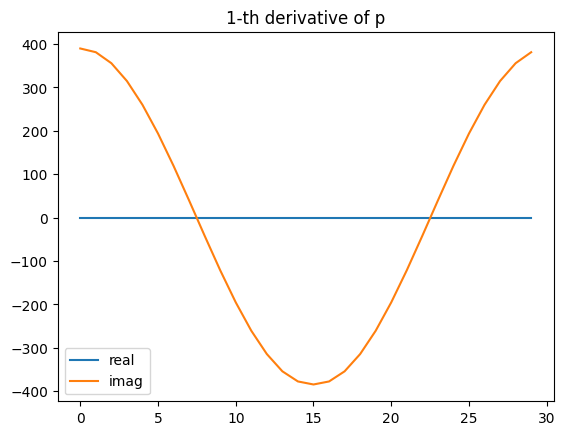

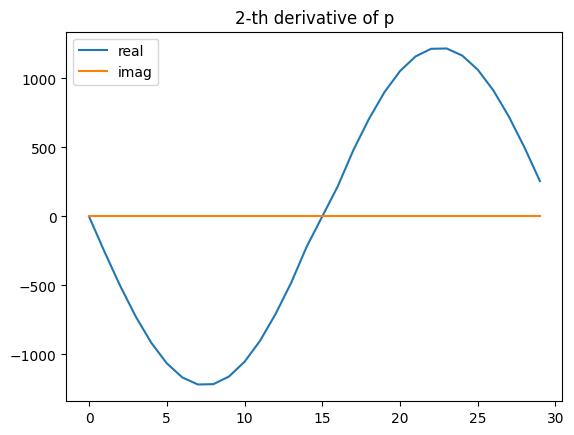

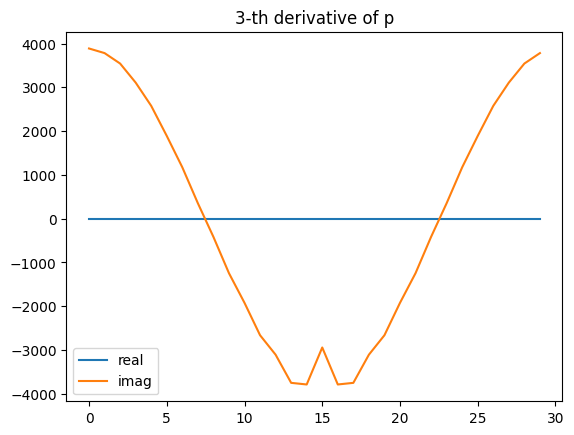

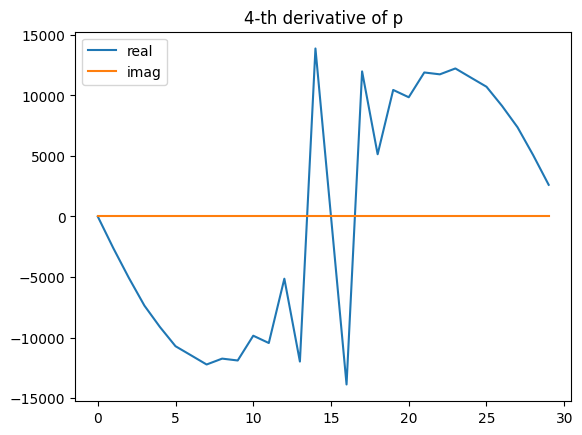

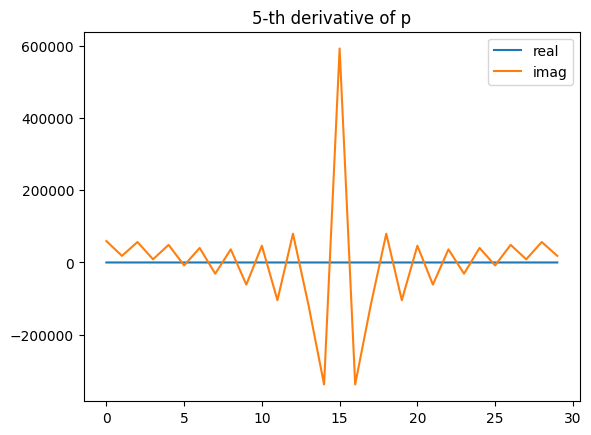

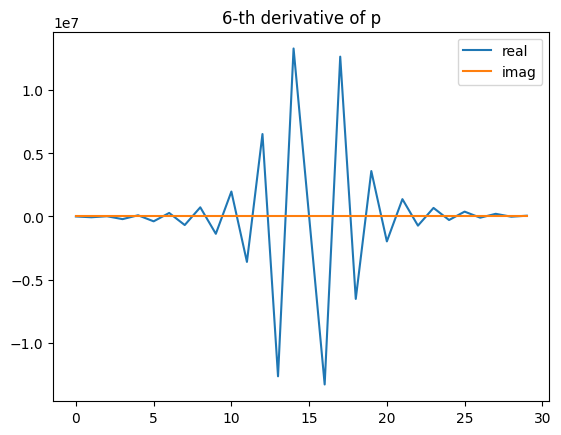

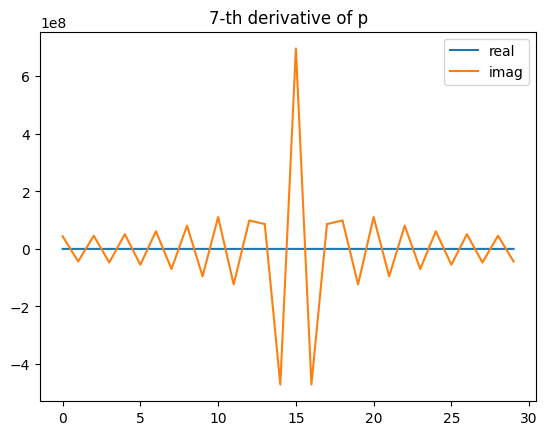

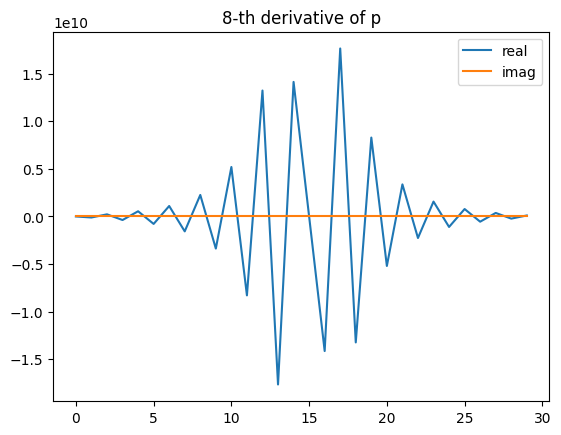

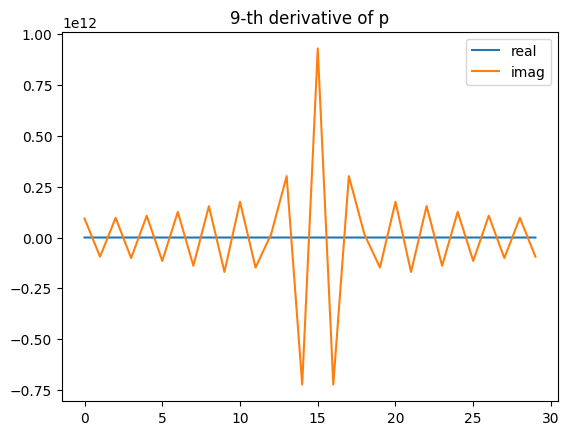

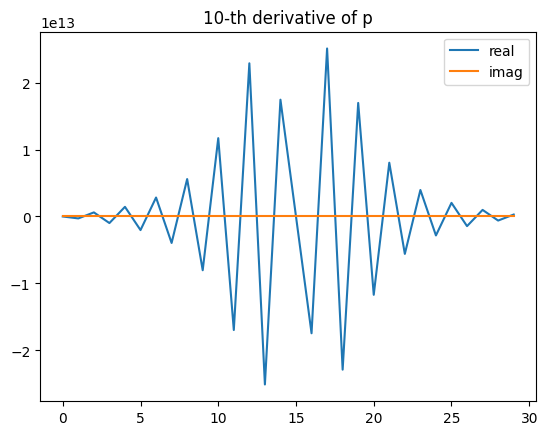

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


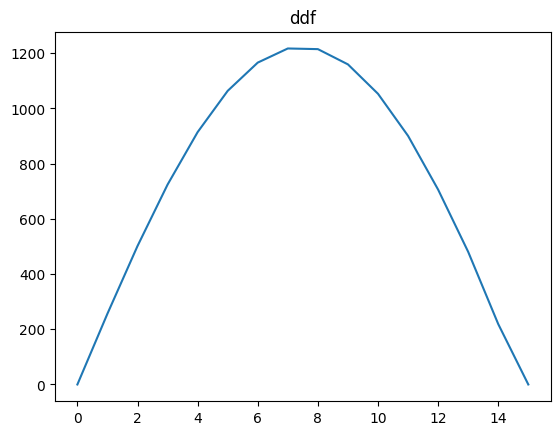

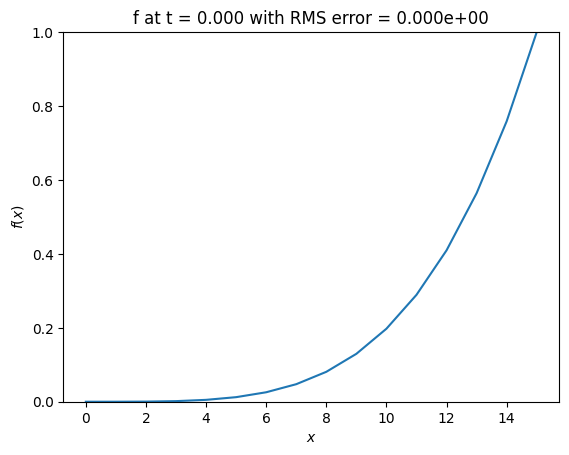

In [15]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt
import scipy 

L                 = 1
N                 = 16
dx                = L/(N - 1)
x                 = np.arange(0, N) * dx
dt                = 1e-4
v                 = 1
t                 = 0.0
tend              = 1.0
r                 = (v * dt)**2
ghostBoundary     = 0
fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_EVEN
derivativeMode    = sd.ONE_SIDED
smoothingOrder    = 8
a, b              = 0, L
xgegenbauer       = (x - (a + b)/2)/ ((b - a)/2)

def func(x, v, t):
    return x**4

f  = func(x, v, t    )

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

#Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug= True)

#Boundary for finite difference stencil
lind =          fdl
rind = len(x) - fdr 

#Subtract linear shift function to enforce Dirichlet BC when computing second derivative
homf            = f[ lind : rind ] - B[0]

plt.title("homf") 
plt.plot(homf) 
plt.show() 

pext           = np.concatenate([homf, -np.flip(homf)[1:-1]])
xext           = np.concatenate([x, x[1:-1] + L])

plt.title("Extended p") 
plt.plot(pext)
plt.show() 

plt.title("First derivative of extended p") 
plt.plot((np.roll(pext, -1) - np.roll(pext, 1))/(2*dx))
plt.show()
plt.title("Second derivative of extended p") 
plt.plot((np.roll(pext, -1) + np.roll(pext, 1) - 2*pext)/(dx**2))
plt.show()

print("The extended p: ", pext)
print(pext[1] - pext[0], pext[-1] - pext[-2])

ext2  = np.concatenate([xext, xext + 2*L])
pext2 = np.concatenate([pext, pext])
plt.title("pext") 
plt.plot(ext2, pext2) 
plt.show() 

T1 = sd.DFT1
p = pext

k = sd.computeK(p, dx, T1)

if len(p) % 2 != 0:
    raise ValueError("Fourier transform does not work well for an uneven number of grid points")

p_hat = scipy.fft.fft(p)

if 1:
    plt.title("p_hat")
    plt.plot(p_hat.real, label="real")
    plt.plot(p_hat.imag, label="imag")
    plt.legend()
    plt.show()

    for i in range(1, 11):
        plt.title(f"{i}-th derivative of p")

        dip = scipy.fft.ifft(p_hat * k**i)

        plt.plot(dip.real, label="real")
        plt.plot(dip.imag, label="imag")
        plt.legend()
        plt.show()



p_hat = p_hat * (-1) * k**2

ddf = scipy.fft.ifft(p_hat)

ddf = ddf[:len(homf)]
plt.title("ddf") 
plt.plot(ddf) 
plt.show() 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()